<h1>Più liberi o più felici?</h1>
<p>Esplorando il Legame Tra Felicità e Libertà Nel Contesto Globale</p>

<h2>Overview</h2>
<p>Questo studio si propone di fornire una panoramica della percezione media mondiale del senso di felicità e del senso di libertà nel periodo compreso tra il 2015 e il 2019. 

Attraverso l'analisi dei dati disponibili, ci proponiamo di rispondere alle seguenti domande:</p>
<ul>
    <li><strong>Distribuzione e Caratteristiche di Felicità e Libertà:</strong> Esploreremo la distribuzione dei livelli di felicità e libertà tra le popolazioni mondiali e identificheremo le caratteristiche che le distinguono. </li>
    <li><strong>Legame tra Felicità e Libertà:</strong> Investigare il legame tra felicità e libertà attraverso l'analisi delle correlazioni tra i dati relativi a questi due concetti. Cercheremo di capire se esiste una relazione significativa tra i due e in che modo si influenzano reciprocamente.</li>
    <li><strong>Percezione Mondiale di Felicità e Libertà:</strong> Esamineremo la percezione mondiale di felicità e libertà nel periodo preso in considerazione, cercando di dare una panoramica per macroaree.</li>
</ul>
<p>Attraverso un'approfondita analisi dei dati raccolti, ci aspettiamo di ottenere una comprensione più accurata della relazione tra felicità e libertà e del loro impatto nelle aree del mondo.</p>

<h2>Overview</h2>

<p>Tramite questo studio, cercheremo di fare una fotografia della percezione media mondiale del senso di <i>felicità</i> e del senso di <i>libertà</i> percepita dal 2015 al 2019.

Per fare questo cercheremo di rispondere alle seguenti domande:

<ul>
    <li>Come si distribuiscono felicità e liberà e cosa le caratterizza?</li>
    <li>Che tipo di legame hanno?</li>
    <li>Come vengono percepite mondialmente?</li>
</ul>
</p>

In [1]:
#import library

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
from sklearn.preprocessing import StandardScaler

import warnings
from shapely.errors import ShapelyDeprecationWarning


<h2>Data Sources</h2>

<p>Per l'analisi sono stati presi in considerazione i seguenti dataset con riferimento agli anni 2015-2019:</p>

<ul>
    <li><a href="https://www.kaggle.com/datasets/gsutters/the-human-freedom-index">Human Freedom</a></li> 
    che offre una panoramica mondiale di come le nazioni percepiscono il senso di libertà
    <li><a href="https://www.kaggle.com/datasets/unsdsn/world-happiness">World Happiness Report</a></li> Che offre una panoramica mondiale di come le nazioni percepiscono il senso di felicità
</ul>

<p>Entrambi i dataset hanno la seguente struttura delle colonne:

<strong>Primary key (country-year):</strong> ogni riga in entrambi i dataset è caratterizzata dalla chiave nazione-anno

<strong>Total Score:</strong> ogni dataset ha una colonna <i>score</i>, che indica il punteggio di felicità o libertà stimato in una scala [0-10]

<strong>Contributors:</strong> una serie di colonne che influenzano il total score rispetto al proprio dataset, relative alle stime per le sottoaree dei loro rispettivi componenti
 </p>

<h2>Data Sources</h2>
<p>Per l'analisi sono stati considerati i seguenti dataset relativi agli anni 2015-2019:</p>
<ul>
    <li><a href="https://www.kaggle.com/datasets/gsutters/the-human-freedom-index">Indice della Libertà Umana</a></li> 
    che fornisce una panoramica mondiale di come le nazioni percepiscono il concetto di libertà.
    <li><a href="https://www.kaggle.com/datasets/unsdsn/world-happiness">Rapporto Mondiale sulla Felicità</a></li> 
    che offre una panoramica mondiale di come le nazioni percepiscono il concetto di felicità.
</ul>
<p>Entrambi i dataset seguono la seguente struttura delle colonne:</p>
<ul>
    <li><strong>Chiave Primaria (nazione-anno):</strong> ogni riga in entrambi i dataset è identificata da una chiave che combina il nome della nazione e l'anno.</li>
    <li><strong>Punteggio Totale:</strong> entrambi i dataset includono una colonna di punteggio, che rappresenta il livello stimato di felicità o libertà su una scala da 0 a 10.</li>
    <li><strong>Contributori:</strong> una serie di colonne che contribuiscono al punteggio totale riflettendo stime relative a sottogruppi specifici delle rispettive aree tematiche.</li>
</ul>

## Glossario

<p>Dopo una prima analisi ai dataset, è stato visto che le colonne del dataset happiness erano abbastanza parlanti, mentre quelle del dataset freedom necessitavano di un glossario a parte.

Le colonne hanno 3 prefissi principali:
<ul>
<li><strong>hf - Human Freedom</strong></li>
<li><strong>pf - Personal Freedom</strong></li>
<li><strong>ef - Economic Freedom</strong></li>
</ul>

</p>


Il personal freedom

In [2]:

# Definizione del dizionario dei dati
data = {
    'hf_score': {'pf_score': {'pf_rol': 'rule&role',
                              'pf_ss': 'security&safety',
                              'pf_movement': 'movement',
                              'pf_religion': 'religion',
                              'pf_expression': 'expression and information',
                              'pf_identity': 'identity and relationship',
                              'pf_association': 'association, assembly and civil society'},
                 'ef_score': {'ef_government': 'government',
                              'ef_gender': 'gender',
                              'ef_legal': 'legal system and property right',
                              'ef_money': 'access to sound money',
                              'ef_trade': 'freedom to trade internationally',
                              'ef_regulation': 'regulation of credit and business'}}
}

# Funzione ricorsiva per creare il diagramma
def plot_tree(data, parent=None, level=0):
    if parent:
        print("  " * level + f"- {parent}")
    for key, value in data.items():
        if isinstance(value, dict):
            plot_tree(value, parent=key, level=level+1)
        else:
            print("  " * (level+1) + f"- {key}: {value}")

# Creazione del diagramma
plot_tree(data)


  - hf_score
    - pf_score
      - pf_rol: rule&role
      - pf_ss: security&safety
      - pf_movement: movement
      - pf_religion: religion
      - pf_expression: expression and information
      - pf_identity: identity and relationship
      - pf_association: association, assembly and civil society
    - ef_score
      - ef_government: government
      - ef_gender: gender
      - ef_legal: legal system and property right
      - ef_money: access to sound money
      - ef_trade: freedom to trade internationally
      - ef_regulation: regulation of credit and business


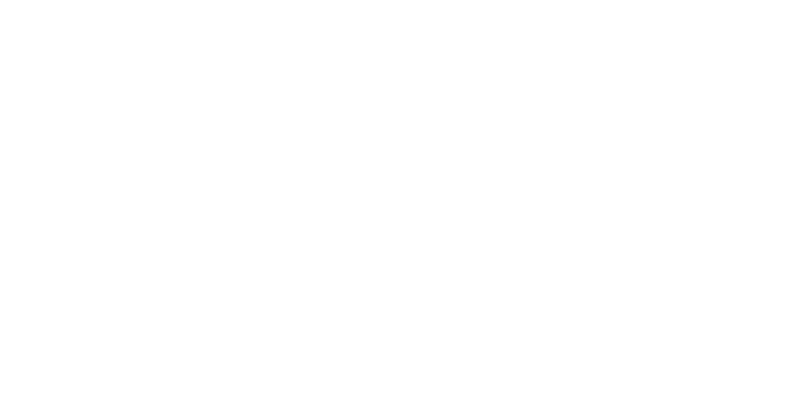

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Definizione del dizionario dei dati
data = {
    'hf_score': {'pf_score': {'pf_rol': 'rule&role',
                              'pf_ss': 'security&safety',
                              'pf_movement': 'movement',
                              'pf_religion': 'religion',
                              'pf_expression': 'expression and information',
                              'pf_identity': 'identity and relationship',
                              'pf_association': 'association, assembly and civil society'},
                 'ef_score': {'ef_government': 'government',
                              'ef_gender': 'gender',
                              'ef_legal': 'legal system and property right',
                              'ef_money': 'access to sound money',
                              'ef_trade': 'freedom to trade internationally',
                              'ef_regulation': 'regulation of credit and business'}}
}

# Funzione ricorsiva per creare il grafico a blocchi
def plot_tree(data, parent=None, level=0, x_offset=0, y_offset=0):
    if parent:
        plt.text(x_offset + 0.5, y_offset + 0.5, parent, ha='center', va='center', fontsize=12, fontweight='bold')
        plt.gca().add_patch(Rectangle((x_offset, y_offset), 1, 1, fill=None, edgecolor='black'))
    children = data.get(parent)
    if children:
        x_offset_child = x_offset - 1
        for key, value in children.items():
            x_offset_child += 1
            plt.text(x_offset_child + 0.5, y_offset - 1, key, ha='center', va='center', fontsize=10)
            plt.text(x_offset_child + 0.5, y_offset - 1.5, value, ha='center', va='center', fontsize=10)
            plt.gca().add_patch(Rectangle((x_offset_child, y_offset - 2), 1, 2, fill=None, edgecolor='black'))
            plot_tree(data, parent=key, level=level+1, x_offset=x_offset_child, y_offset=y_offset-2)

# Creazione del grafico a blocchi
plt.figure(figsize=(10, 5))
plot_tree(data)
plt.xlim(-1, 10)
plt.ylim(-1, 5)
plt.axis('off')
plt.show()


/Users/malefica/opt/anaconda3/envs/s2i/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


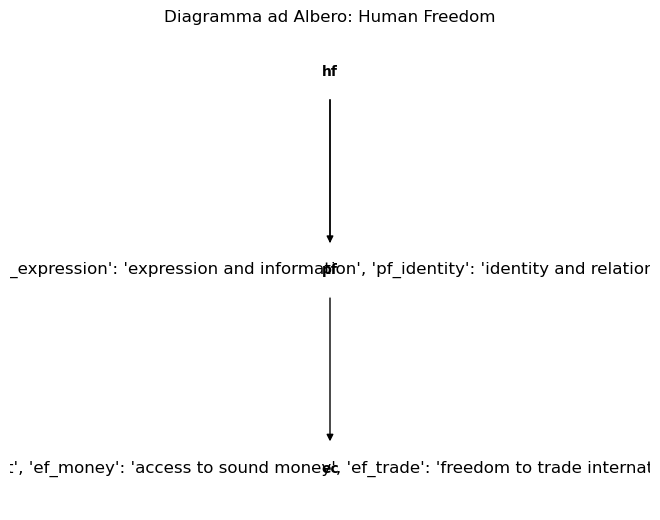

In [64]:
import matplotlib.pyplot as plt
import networkx as nx

# Definizione del dizionario dei dati
data = {
    'hf': {'pf': {'pf_rol': 'rule&role',
                  'pf_ss': 'security&safety',
                  'pf_movement': 'movement',
                  'pf_religion': 'religion',
                  'pf_expression': 'expression and information',
                  'pf_identity': 'identity and relationship',
                  'pf_score': 'personal freedom score',
                  'pf_association': 'association, assembly and civil society'},
           'ef': {'ef_government': 'government',
                  'ef_gender': 'gender',
                  'ef_legal': 'legal system and property right',
                  'ef_money': 'access to sound money',
                  'ef_trade': 'freedom to trade internationally',
                  'ef_regulation': 'regulation of credit and business',
                  'ef_score': 'economic freedom score'}}
}

# Funzione ricorsiva per la creazione del diagramma ad albero
def create_tree(G, node, parent=None, color='white', subset=None):
    G.add_node(node, fillcolor=color, style='filled', partition=subset)
    if parent:
        G.add_edge(parent, node)
    children = data.get(node)
    if children:
        for child, label in children.items():
            create_tree(G, child, node, subset=subset)
            G.add_node(child, label=label)

# Creazione del grafo
G = nx.DiGraph()

# Creazione dell'albero
create_tree(G, 'hf', subset=0)

# Impostazione dei colori per i nodi
node_colors = [G.nodes[n]['fillcolor'] for n in G.nodes]

# Disegno del grafo
pos = nx.multipartite_layout(G, subset_key="partition")
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1500, font_size=10, font_weight='bold', cmap=plt.cm.Blues)

# Impostazione delle etichette dei nodi
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, font_color='black')

# Mostra il diagramma
plt.title('Diagramma ad Albero: Human Freedom')
plt.show()


In [5]:
#import dataset

#human_freedom
hf22 = pd.read_csv('dataset/human_freedom_index/hfi_cc_2022.csv')

#world_happiness
wh15 = pd.read_csv('dataset/world_happiness_report/2015.csv')
wh16 = pd.read_csv('dataset/world_happiness_report/2016.csv')
wh17 = pd.read_csv('dataset/world_happiness_report/2017.csv')
wh18 = pd.read_csv('dataset/world_happiness_report/2018.csv')
wh19 = pd.read_csv('dataset/world_happiness_report/2019.csv')

# geospatial data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Data Cleaning

<p>Di seguito verrà fatta un operazione di data cleaning per i 2 dataset separatamente. 
Dopo questa prima fase, seguirà una valutazione della consistenza dei dati tra i due dataset e il dataset world</p>

## Human Freedom - Data Cleaning

In [6]:
hf22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3465 entries, 0 to 3464
Columns: 141 entries, year to ef_rank
dtypes: float64(133), int64(3), object(5)
memory usage: 3.7+ MB


In [7]:
hf22.sample(5)

,year,countries,region,hf_score,hf_rank,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol_vdem,...,ef_regulation_business_adm,ef_regulation_business_burden,ef_regulation_business_start,ef_regulation_business_impartial,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_score,ef_rank
2431,2006,Philippines,South Asia,7.29,76.0,3.0,NaN,NaN,NaN,5.691990,...,2.539201,4.276730,7.786378,5.0475,7.422934,7.814181,5.814487,6.995003,6.96,69.0
2272,2007,Rwanda,Sub-Saharan Africa,6.28,111.0,4.0,NaN,NaN,NaN,5.400710,...,NaN,NaN,8.407832,7.5525,6.395331,8.206508,7.640543,7.829513,6.41,95.0
2438,2006,Saudi Arabia,Middle East & North Africa,NaN,NaN,NaN,NaN,NaN,NaN,3.549084,...,NaN,NaN,NaN,5.3575,NaN,NaN,NaN,NaN,NaN,NaN
1952,2009,South Africa,Sub-Saharan Africa,7.29,72.0,3.0,5.9,5.470206,4.932219,6.983530,...,3.331768,2.362869,9.232610,7.3700,8.039560,7.758135,6.349157,7.182032,6.78,80.0
3099,2002,Senegal,Sub-Saharan Africa,6.78,77.0,3.0,NaN,NaN,NaN,6.756241,...,2.000000,5.750000,6.070581,5.9775,NaN,2.198309,4.399278,5.440321,5.78,99.0


In [ ]:
hf22.rename(columns = {'countries':'country'}, inplace = True) 

#Since assembly is a subarea of ​​association, the columns were renamed correctly
hf22.columns = ['pf_association_assembly' + c.split('pf_assembly', 1)[1] if c.startswith('pf_assembly') else c for c in hf22.columns]
hf22['pf_association'] = hf22['pf_association_assembly']

In [ ]:
#get all rows between [2015-2019]
freedom_data = hf22[(hf22['year'] >= 2015) & (hf22['year'] <= 2019)]
freedom_data.reset_index(inplace=True)

In [ ]:
#get only relevant columns
principal_columns = [c for c in freedom_data.columns.values if c.count('_') <= 1]
freedom_data = freedom_data[principal_columns]

#the columns not of interest are eliminated
freedom_data = freedom_data.drop(['index', 'hf_rank', 'hf_quartile', 'pf_rank', 'ef_rank'], axis=1)
freedom_data.info()

In [ ]:
freedom_data.describe()

In [ ]:
freedom_data.filter(like='ef_').describe()

<p>'ef_gender' ha un andamento anomalo. 
I suoi valori oscillano tra [0-1] piuttosto che tra [0-10].
La media tra tutti i valori delle colonne relative all'analisi della libertà, non restisce ef_score se presa in considerazione la colonna ef_gender.

Per questi motivi è stato scelto di eliminare la colonna 
</p>

In [ ]:
freedom_data = freedom_data.drop(['ef_gender'], axis=1)

In [ ]:
#get info about principal columns in freedom_data dataframe
freedom_data[["hf_score", "pf_score", "ef_score"]].info()

In [ ]:
freedom_data[freedom_data[["hf_score", "pf_score", "ef_score"]].isna().any(axis=1)].info()

Le colonne "hf_score", "pf_score", "ef_score", sono particolarmente significative. Per questo motivo è stato deciso di eliminare le righe che hanno almeno una dei 3 campi valorizzato a nan, valutando essere un numero esiguo (15/825).

In [ ]:
freedom_data.dropna(subset=["hf_score", "pf_score", "ef_score"], how='any', inplace=True)
freedom_data[["hf_score", "pf_score", "ef_score"]].info()

In [ ]:
freedom_data.head(5)

In [ ]:
freedom_data[['hf_score', 'pf_score', 'ef_score']].describe()

## Happiness Report - Data Cleaning

In [ ]:
#Uniform columns between dataset

#drop columns 
wh15 = wh15.drop(columns=['Region', 'Standard Error', 'Dystopia Residual'], axis=1)
wh16 = wh16.drop(columns=['Region', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Dystopia Residual'], axis=1)
wh17 = wh17.drop(columns=['Whisker.high', 'Whisker.low', 'Dystopia.Residual'], axis=1)


#rename columns
wh19 = wh19.rename(columns={"Country or region": "country",
                     "Overall rank": "happiness_rank", 
                     "Score": "happiness_score",
                     "GDP per capita": "economy",
                     "Social support": "family",
                     "Healthy life expectancy": "health",
                     "Freedom to make life choices": "freedom",
                     "Perceptions of corruption": "trust",
                     "Generosity": "generosity"
                     })

wh18 = wh18.rename(columns={"Country or region": "country",
                     "Overall rank": "happiness_rank", 
                     "Score": "happiness_score",
                     "GDP per capita": "economy",
                     "Social support": "family",
                     "Healthy life expectancy": "health",
                     "Freedom to make life choices": "freedom",
                     "Perceptions of corruption": "trust",
                     "Generosity": "generosity"
                     })

wh17 = wh17.rename(columns={"Country": "country",
                     "Happiness.Rank": "happiness_rank", 
                     "Happiness.Score": "happiness_score",
                     "Economy..GDP.per.Capita.": "economy",
                     "Family": "family",
                     "Health..Life.Expectancy.": "health",
                     "Freedom": "freedom",
                     "Trust..Government.Corruption.": "trust",
                     "Generosity": "generosity"
                     })

wh16 = wh16.rename(columns={"Country": "country",
                     "Happiness Rank": "happiness_rank", 
                     "Happiness Score": "happiness_score",
                     "Economy (GDP per Capita)": "economy",
                     "Family": "family",
                     "Health (Life Expectancy)": "health",
                     "Freedom": "freedom",
                     "Trust (Government Corruption)": "trust",
                     "Generosity": "generosity"
                     })

wh15 = wh15.rename(columns={"Country": "country",
                     "Happiness Rank": "happiness_rank", 
                     "Happiness Score": "happiness_score",
                     "Economy (GDP per Capita)": "economy",
                     "Family": "family",
                     "Health (Life Expectancy)": "health",
                     "Freedom": "freedom",
                     "Trust (Government Corruption)": "trust",
                     "Generosity": "generosity"
                     })

#add column year for every dataframe
wh15['year'] = 2015
wh16['year'] = 2016
wh17['year'] = 2017
wh18['year'] = 2018
wh19['year'] = 2019

frames = [wh15, wh16, wh17, wh18, wh19]
happiness_data = pd.concat(frames)

In [ ]:
happiness_data.info()
print("Unique countries: ", happiness_data.country.nunique())

In [ ]:
happiness_data = happiness_data.drop(columns=['happiness_rank'])

Rendiamo i dataframe consistenti tra loro

In [ ]:
print(freedom_data[~freedom_data['country'].isin(world['name'])]['country'].unique())
print('')
print(happiness_data[~happiness_data['country'].isin(world['name'])]['country'].unique())

In [ ]:
happiness_data['country'] = happiness_data['country'].replace(['Bosnia and Herzegovina'], 'Bosnia and Herz.')
happiness_data['country'] = happiness_data['country'].replace(['Central African Republic'], 'Central African Rep.')
happiness_data['country'] = happiness_data['country'].replace(['Congo (Brazzaville)'], 'Congo')
happiness_data['country'] = happiness_data['country'].replace(['Congo (Kinshasa)'], 'Dem. Rep. Congo')
happiness_data['country'] = happiness_data['country'].replace(['Czech Republic'], 'Czechia')
happiness_data['country'] = happiness_data['country'].replace(['Dominican Republic'], 'Dominican Rep.')
happiness_data['country'] = happiness_data['country'].replace(['Hong Kong S.A.R., China'], 'Hong Kong')
happiness_data['country'] = happiness_data['country'].replace(['Ivory Coast'], "Côte d'Ivoire")
happiness_data['country'] = happiness_data['country'].replace(['North Cyprus'], 'Cyprus')
happiness_data['country'] = happiness_data['country'].replace(['Northern Cyprus'], 'Cyprus')
happiness_data['country'] = happiness_data['country'].replace(['North Macedonia'], 'Macedonia')
happiness_data['country'] = happiness_data['country'].replace(['Palestinian Territories'], 'Palestine')
happiness_data['country'] = happiness_data['country'].replace(['Somaliland region'], 'Somaliland Region')
happiness_data['country'] = happiness_data['country'].replace(['South Sudan'], 'S. Sudan')
happiness_data['country'] = happiness_data['country'].replace(['Swaziland'], 'eSwatini')
happiness_data['country'] = happiness_data['country'].replace(['Taiwan Province of China'], 'Taiwan')
happiness_data['country'] = happiness_data['country'].replace(['Trinidad & Tobago'], 'Trinidad and Tobago')
happiness_data['country'] = happiness_data['country'].replace(['United States'], 'United States of America')

freedom_data['country'] = freedom_data['country'].replace(['Bahamas, The'], 'Bahamas')
freedom_data['country'] = freedom_data['country'].replace(['Bosnia and Herzegovina'], 'Bosnia and Herz.')
freedom_data['country'] = freedom_data['country'].replace(['Central African Republic'], 'Central African Rep.')
freedom_data['country'] = freedom_data['country'].replace(['Congo, Dem. Rep.'], 'Dem. Rep. Congo')
freedom_data['country'] = freedom_data['country'].replace(['Congo, Rep.'], 'Congo')
freedom_data['country'] = freedom_data['country'].replace(["Cote d'Ivoire"], "Côte d'Ivoire")
freedom_data['country'] = freedom_data['country'].replace(['Czech Republic'], 'Czechia')
freedom_data['country'] = freedom_data['country'].replace(['Dominican Republic'], 'Dominican Rep.')
freedom_data['country'] = freedom_data['country'].replace(['Egypt, Arab Rep.'], 'Egypt')
freedom_data['country'] = freedom_data['country'].replace(['Eswatini'], 'eSwatini')
freedom_data['country'] = freedom_data['country'].replace(['Gambia, The'], 'Gambia')
freedom_data['country'] = freedom_data['country'].replace(['Hong Kong SAR, China'], 'Hong Kong')
freedom_data['country'] = freedom_data['country'].replace(['Iran, Islamic Rep.'], 'Iran')
freedom_data['country'] = freedom_data['country'].replace(['Korea, Rep.'], 'South Korea')
freedom_data['country'] = freedom_data['country'].replace(['Kyrgyz Republic'], 'Kyrgyzstan')
freedom_data['country'] = freedom_data['country'].replace(['Lao PDR'], 'Laos')
freedom_data['country'] = freedom_data['country'].replace(['North Macedonia'], 'Macedonia')
freedom_data['country'] = freedom_data['country'].replace(['Slovak Republic'], 'Slovakia')
freedom_data['country'] = freedom_data['country'].replace(['Syrian Arab Republic'], 'Syria')
freedom_data['country'] = freedom_data['country'].replace(['Venezuela, RB'], 'Venezuela')
freedom_data['country'] = freedom_data['country'].replace(['United States'], 'United States of America')
freedom_data['country'] = freedom_data['country'].replace(['Yemen, Rep.'], 'Yemen')

In [ ]:
print(freedom_data[~freedom_data['country'].isin(world['name'])]['country'].unique())
print('')
print(happiness_data[~happiness_data['country'].isin(world['name'])]['country'].unique())

In [ ]:
happy_free = pd.merge(happiness_data, freedom_data,  how='inner', left_on=['country','year'], right_on = ['country','year']).sort_values('country')

In [ ]:
happy_free.sample(5)

In [ ]:
happiness_data[happiness_data.country == 'Russia']

<h1>Libertà e Felicità</h1>
<p>Cosa sono? Di cosa sono fatte?</p>

<h2>Libertà e Felicità</h2>

<p>I dataset selezionati, contengono i risultati di questionari, sottoposti alla maggior parte delle nazioni mondiali, inerenti alle sensazioni che si percepiscono rispetto alla libertà e alla felicità.</p>
<p>Entrambi i dataset resistuiscono un valore globale, misurabile in una scala da 0 a 10, che indica la percezione che ha una specifica nazione, di libertà e felicità.</p>
<p>Ogni dataset ha inoltre al proprio interno, una serie di variabili che rappresentano una valutazione rispetto ai macroambiti che influenzano la libertà e la felicità.</p>

<h2>Libertà e Felicità - Distribuzione</h2>

<p>Per meglio capire i dati contenuti nei dataset andremo ad aiutarci con dei grafici che ci chiariranno i seguenti aspetti:</p>

<ul>
<li>Come si distribuiscono Libertà e Felicità</li>
<li>Da cosa sono influenzate Libertà e Felicità</li>
</ul>

In [ ]:
def show_boxplot():
    plt.figure(figsize=(6, 6))
    boxplot = plt.boxplot([happy_free['hf_score'], happy_free['happiness_score']], patch_artist=True, labels=['libertà', 'felicità'], widths=0.7)

    boxplot['boxes'][0].set(facecolor='#FF6666')
    boxplot['boxes'][1].set(facecolor='#98FB98')

    for median in boxplot['medians']:
        median.set(color='black')

    plt.title('Distribuzione delle variabili libertà e felicità')

    plt.show()

In [ ]:
show_boxplot()

<h2>Di cosa è fatta la libertà?</h2>

In [ ]:
data = {'pf_rol': 'rule&role',
        'pf_ss': 'security&safety',
        'pf_movement': 'movement',
        'pf_religion': 'religion',
        'pf_expression': 'expression and information',
        'pf_identity': 'identity and relationship',
        'pf_score': 'personal freedom score',
        'ef_government': 'government',
        'ef_gender': 'gender',
        'ef_legal': 'legal system and property right',
        'ef_money': 'access to sound money',
        'ef_trade': 'freedom to trade internationally',
        'ef_regulation': 'regulation of credit and business',
        'ef_score': 'economic freedom score',
        'pf_association': 'association, assembly and civil society'}

In [ ]:
#Calcolo la serie delle percentuali

freedom_mean = freedom_data.select_dtypes(include=['number']).mean()
freedom_mean = freedom_mean.drop(labels=['year'])

personal_freedom_columns = ['pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression', 'pf_identity', 'pf_association']
economic_freedom_columns = ['ef_government', 'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation']

total_human_freedom = freedom_mean[['pf_score', 'ef_score']].sum()
total_personal_freedom = freedom_mean[personal_freedom_columns].sum()
total_economic_freedom = freedom_mean[economic_freedom_columns].sum()


h_freedom_percentage = freedom_mean[['pf_score', 'ef_score']]/total_human_freedom
p_freedom_percentage = freedom_mean[personal_freedom_columns]/total_personal_freedom * h_freedom_percentage.pf_score
e_freedom_percentage = freedom_mean[economic_freedom_columns]/total_economic_freedom * h_freedom_percentage.ef_score

freedom_percentage = pd.concat([h_freedom_percentage, p_freedom_percentage, e_freedom_percentage]) * 100

In [ ]:
#create pie plot
principal_values = freedom_percentage[['pf_score', 'ef_score']].values
principal_labels = freedom_percentage[['pf_score', 'ef_score']].index

detail_values = freedom_percentage[personal_freedom_columns + economic_freedom_columns].values
detail_labels = freedom_percentage[personal_freedom_columns + economic_freedom_columns].index

blue_colors = sns.color_palette("Blues", 7)
orange_colors = sns.color_palette("Oranges", 5)
colors = blue_colors + orange_colors


# Converti i colori in codice esadecimale
personal_colors = [sns.palettes.color_palette([color]).as_hex()[0] for color in blue_colors]
economic_colors = [sns.palettes.color_palette([color]).as_hex()[0] for color in blue_colors]

In [37]:
label_test = ['rule&rol', 'security&safety', 'movement', 'religion', 'expression and information',
       'identity and relationship', 'association, assembly and civil society', 'government', 'legal system and property right',
       'access to sound money', 'freedom to trade internationally', 'regulation of credit and business']

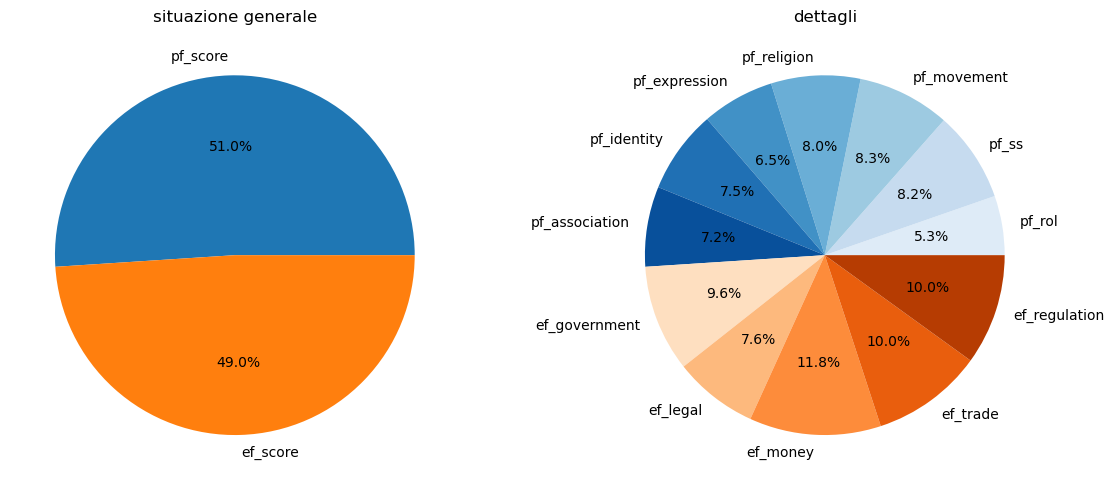

In [36]:
principal_labels = freedom_percentage[['pf_score', 'ef_score']].index

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(principal_values, labels=principal_labels, autopct='%1.1f%%')
plt.title('situazione generale')

plt.subplot(1, 2, 2)
plt.pie(detail_values, labels=detail_labels, colors=colors , autopct='%1.1f%%')
#plt.pie(detail_values, labels=label_test, colors=colors , autopct='%1.1f%%')
plt.title('dettagli')


plt.tight_layout()

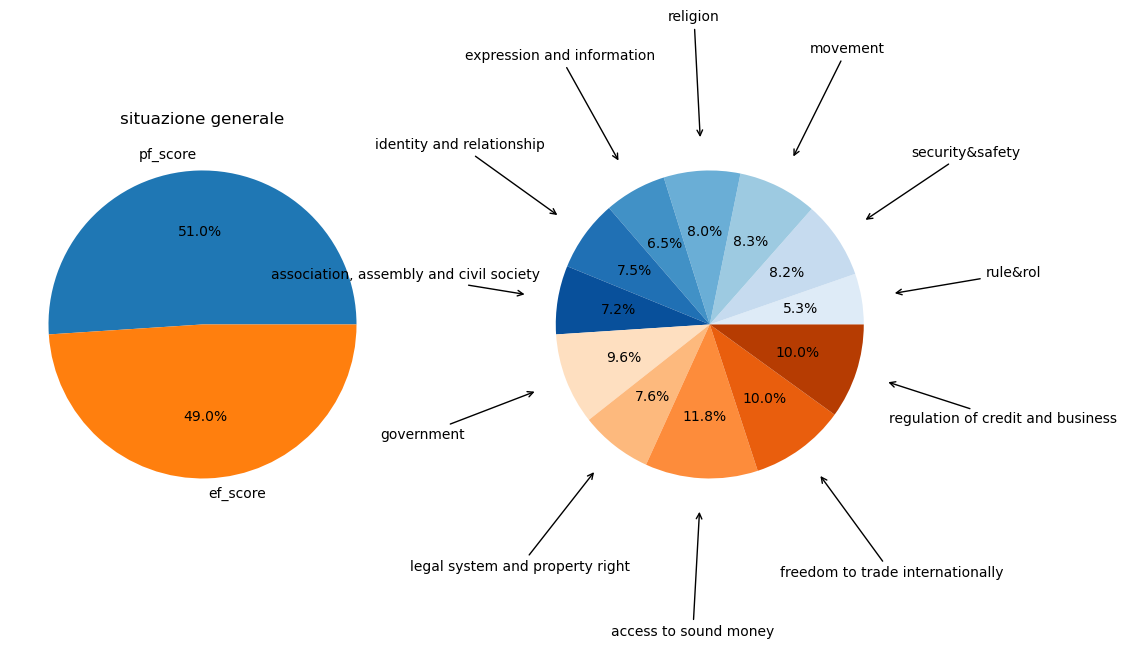

In [40]:
principal_labels = freedom_percentage[['pf_score', 'ef_score']].index

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(principal_values, labels=principal_labels, autopct='%1.1f%%')
plt.title('situazione generale')

plt.subplot(1, 2, 2)
plt.pie(detail_values, colors=colors , autopct='%1.1f%%')
#plt.title('dettagli')

# Calcola i valori necessari per posizionare le etichette
angles = np.cumsum(detail_values / sum(detail_values) * 360)
mid_angles = (angles - 0.5 * detail_values / sum(detail_values) * 360) * np.pi / 180

# Aggiungi le etichette e le frecce
for angle, mid_angle, label in zip(angles, mid_angles, label_test):
    radius = 1.2
    x_arrow = radius * np.cos(mid_angle)
    y_arrow = radius * np.sin(mid_angle)
    plt.annotate(label, xy=(x_arrow, y_arrow), xytext=(2*np.cos(mid_angle), 2*np.sin(mid_angle)),
                 horizontalalignment='center', verticalalignment='center',
                 arrowprops=dict(facecolor='black', arrowstyle='->'))


In [ ]:

plt.tight_layout()
plt.show()

In [ ]:
principal_labels = freedom_percentage[['pf_score', 'ef_score']].index

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(principal_values, labels=principal_labels, autopct='%1.1f%%')
plt.title('situazione generale')

plt.subplot(1, 2, 2)
plt.pie(detail_values, labels=label_test, colors=colors , autopct='%1.1f%%')
plt.title('dettagli')

# Aggiungi la legenda per le parti del pie plot
plt.legend(label_test, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


In [ ]:
for idx in detail_labels:
    #print(detail_labels)
    print(idx)
    print(data[idx])

<h2>Di cosa è fatta la felicità?</h2>

In [ ]:
principal_columns = ['economy', 'family', 'health', 'freedom', 'trust', 'generosity']

happiness_mean = happiness_data[principal_columns].mean()
happiness_percentage = (happiness_mean / happiness_mean.sum()) * 100

In [ ]:
# Happyness pie plot
plt.figure(figsize=(5, 5))
plt.pie(happiness_percentage, labels=happiness_percentage.index, autopct='%1.1f%%', startangle=140)
plt.title('Da cosa è composta la felicità?')
plt.show()

<h1>Libertà e Felicità: che relazione hanno?</h1>

<h2>Relazione tra felicità e libertà</h2>

<p>Di seguito andremo ad analizzare la relazione che c'è tra libertà e felicità.

A supporto dell'analisi verranno generati i seguenti grafici:
<ul>
    <li><b>Grafico a dispersione</b></li> che permetterà di valutare l'effettiva relazione tra felicità e libertà
    <li><b>Heatmap</b></li> che permetterà di valutare la relazione tra i componenti di felicità e libertà
</ul>
</p>

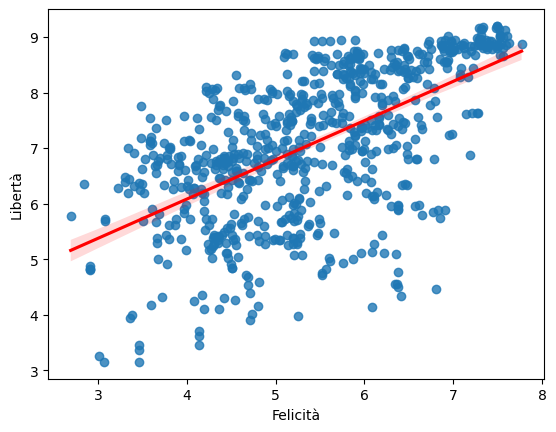

In [41]:
sns.regplot(data=happy_free, x="happiness_score", y="hf_score", order=1, line_kws=dict(color="r"))
plt.xlabel('Felicità')
plt.ylabel('Libertà')
plt.show()

In [42]:
coefficients = np.polyfit(happy_free.happiness_score, happy_free.hf_score, 1)
m, b = coefficients

y = {m}x + {b}

plt.scatter(happy_free.happiness_score, happy_free.hf_score)
plt.plot(happy_free.happiness_score, m*happy_free.happiness_score + b, color='red', label='Regressione lineare')
#plt.xlabel('Felicità'), plt.ylabel('Libertà')
plt.title('scatterplot Felicità-Libertà')
plt.show()

<p>
Di seguito verranno mostrate le heatmap che rappresentano la correlazione tra
<ul>
    <li>felicità-libertà personale</li>
    <li>felicità-libertà economica</li>
</ul>
</p>

In [44]:
heatmap_happy_pfreedom = happy_free[['economy', 'family', 'health',
       'freedom', 'trust', 'generosity',
       'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
       'pf_identity', 'pf_score','pf_association']]  

heatmap_happy_efreedom = happy_free[['economy', 'family', 'health',
       'freedom', 'trust', 'generosity', 'ef_government', 'ef_legal', 'ef_money',
       'ef_trade', 'ef_regulation']]  

corr_happy_pfreedom = heatmap_happy_pfreedom.corr()
corr_happy_efreedom = heatmap_happy_efreedom.corr()

In [45]:
heatmap_columns = happy_free[['economy', 'family', 'health',
       'freedom', 'trust', 'generosity',
       'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
       'pf_identity', 'pf_score', 'ef_government', 'ef_legal', 'ef_money',
       'ef_trade', 'ef_regulation', 'pf_association']]  


corr_matrix = heatmap_columns.corr()

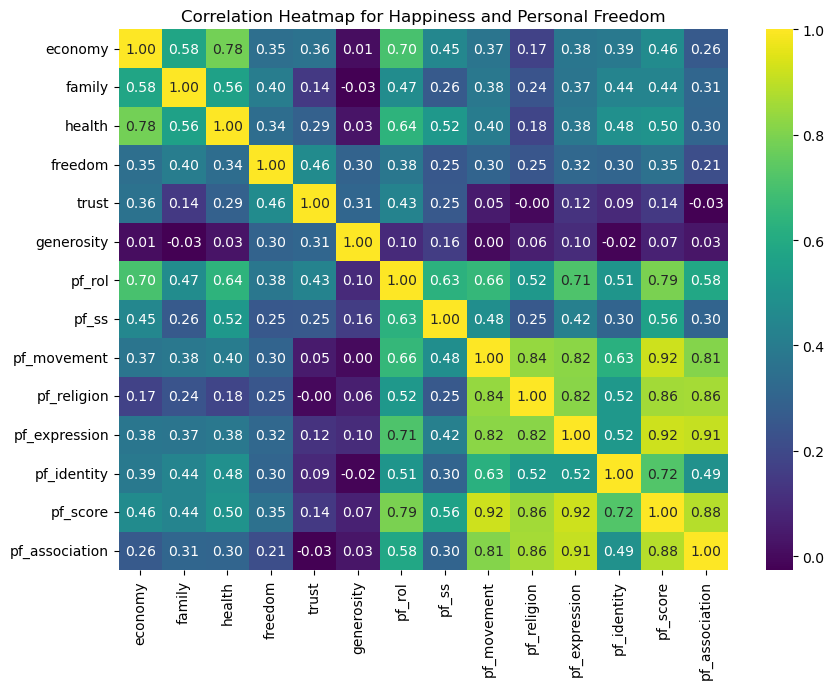

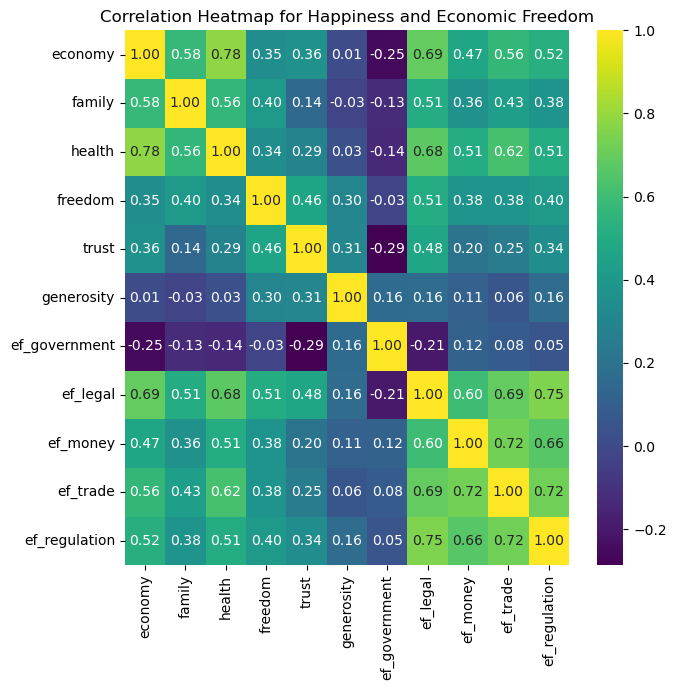

In [62]:
# Grafico della heatmap per happy_pfreedom
plt.figure(figsize=(9, 7))
sns.heatmap(corr_happy_pfreedom, cmap='viridis', annot=True, fmt=".2f")
plt.title('Correlation Heatmap for Happiness and Personal Freedom')
#plt.xlabel('Features')
#plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Grafico della heatmap per happy_efreedom
plt.figure(figsize=(7, 7))
sns.heatmap(corr_happy_efreedom, cmap='viridis', annot=True, fmt=".2f")
plt.title('Correlation Heatmap for Happiness and Economic Freedom')
#plt.xlabel('Features')
#plt.ylabel('Features')
plt.tight_layout()
plt.show()


<h1>Libertà e Felicità: come vengono percepite nel mondo?</h1>

<h4>Data Transformation</h4>
Finora abbiamo usato il dataframe 'happy_free' come inner join tra i dataframe 'freedom_data' e 'happiness_data', scelta nata dall'esigenza di non avere dati non valorizzati all'interno delle celle rispetto ai grafici finora prodotti.
Durante la prossima fase di esplorazione, la scelta di procedere con con un'unione così stringente della merge non è sembrata ottimale in quanto causerebbe perdita di dati che invece sarebbe comunque interessante osservare visivamente.

Si procede alla trasformazione del dataframe happy_free:

In [47]:
happy_free_outer = pd.merge(happiness_data, freedom_data,  how='outer', left_on=['country','year'], right_on = ['country','year']) 

In [48]:
happy_free_outer[happy_free_outer['country']== 'Russia']

,country,happiness_score,economy,family,health,freedom,trust,generosity,year,region,...,pf_expression,pf_identity,pf_score,ef_government,ef_legal,ef_money,ef_trade,ef_regulation,ef_score,pf_association
63,Russia,5.716,1.137640,1.236170,0.669260,0.366790,0.030050,0.001990,2015,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,Russia,5.856,1.232280,1.052610,0.589910,0.326820,0.035860,0.027360,2016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,Russia,5.963,1.281778,1.469282,0.547349,0.373783,0.032963,0.052264,2017,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
529,Russia,5.810,1.151000,1.479000,0.599000,0.399000,0.025000,0.065000,2018,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693,Russia,5.648,1.183000,1.452000,0.726000,0.334000,0.031000,0.082000,2019,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
columns = happy_free_outer.select_dtypes(include=['float64', 'int64']).columns
columns = columns.drop(['year'])
grouped_by_country = happy_free_outer.groupby('country', as_index=False)[columns].mean()

In [50]:
grouped_by_country = grouped_by_country[['country', 'happiness_score', 'hf_score']]

In [51]:
#tramite la libreria sklearn, vengono normalizzati i dati in modo che in fase di presentazione del grafico, i gap tra stati siano più evidenti
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(happy_free_outer[columns].to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=happy_free_outer[columns].columns.values)
df_scaled = pd.concat((df_scaled, grouped_by_country.country), axis=1)

In [52]:
world_merged = world.merge(df_scaled, left_on='name', right_on='country')

# Calcola il centroide di ogni geometria poligonale
world_merged['centroid'] = world_merged['geometry'].centroid

# Estrai le coordinate x e y dal centroide
world_merged['centroid_x'] = world_merged['centroid'].x
world_merged['centroid_y'] = world_merged['centroid'].y

# Aggiungi un offset per spostare i valori sopra lo zero
offset = abs(world_merged['happiness_score'].min()) + 1
world_merged['happiness_score_shifted'] = world_merged['happiness_score'] + offset

# Applica lo StandardScaler
std_scaler = StandardScaler()
world_merged['happiness_score_scaled'] = std_scaler.fit_transform(world_merged[['happiness_score_shifted']])

# Calcola le dimensioni delle bolle basate sui valori scalati dell'happiness_score
bubble_sizes = np.abs(world_merged['happiness_score_scaled']) * 20

/var/folders/w_/dv5r5z3j0xx6g2nks8s390lm0000gn/T/ipykernel_29151/4191958976.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  world_merged['centroid'] = world_merged['geometry'].centroid


In [ ]:
world_merged.head()

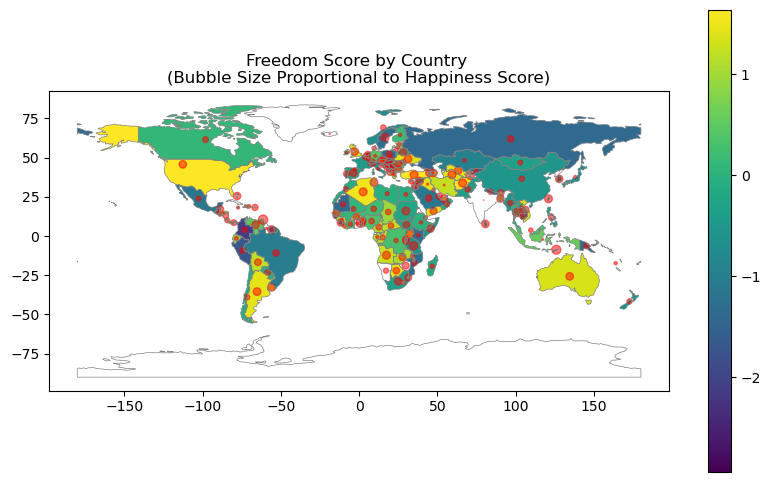

In [53]:
#this command to avoid ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# Crea un grafico con geopandas
fig, ax = plt.subplots(figsize=(10, 6))
world_merged.plot(column='hf_score', cmap='viridis', legend=True, ax=ax)

# Aggiungi le bolle colorate in base all'happiness_score
ax.scatter(world_merged['centroid_x'], world_merged['centroid_y'], 
            s=bubble_sizes, color='red', alpha=0.5)

# Aggiungi le linee dei confini degli stati
world.boundary.plot(ax=ax, color='gray', linewidth=0.5)

plt.title('Freedom Score by Country \n(Bubble Size Proportional to Happiness Score)')
plt.show()

In [ ]:
world_merged.hf_score.describe()

In [ ]:
happy_free_by_country = happy_free[['country', 'happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']].groupby('country', as_index=False).mean()

numeric_columns = happy_free_by_country.select_dtypes(include=[np.number])


In [ ]:
df_scaled.shape

In [ ]:
happy_free.info()

In [ ]:
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(numeric_columns.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=numeric_columns.columns.values)
df_scaled = df_scaled.add_suffix('_scaled')
df_scaled = pd.concat((df_scaled, happy_free_by_country), axis=1)

# Unisci i dati geospaziali con i dati aggregati per country
world_merged = world.merge(df_scaled, left_on='name', right_on='country')


# Aggiungi un offset per spostare i valori sopra lo zero dell'happiness_score
offset = abs(world_merged['happiness_score'].min()) + 1
world_merged['happiness_score_shifted'] = world_merged['happiness_score_scaled'] + offset

# Applica lo StandardScaler
world_merged['happiness_score_scaled'] = std_scaler.fit_transform(world_merged[['happiness_score_shifted']])

# Calcola le dimensioni delle bolle basate sui valori scalati dell'happiness_score
bubble_sizes = np.abs(world_merged['happiness_score_scaled']) * 20


# Calcola il centroide di ogni geometria poligonale
world_merged['centroid'] = world_merged['geometry'].centroid

# Estrai le coordinate x e y dal centroide
world_merged['centroid_x'] = world_merged['centroid'].x
world_merged['centroid_y'] = world_merged['centroid'].y

In [ ]:
world_merged[world_merged['country']=='Russia']

In [ ]:
#this command to avoid ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# Crea un grafico con geopandas
fig, ax = plt.subplots(figsize=(10, 6))
world_merged.plot(column='hf_score', cmap='viridis', legend=True, ax=ax)

# Aggiungi le bolle colorate in base all'happiness_score
ax.scatter(world_merged['centroid_x'], world_merged['centroid_y'], 
            s=bubble_sizes, color='red', alpha=0.5)

# Aggiungi le linee dei confini degli stati
world.boundary.plot(ax=ax, color='gray', linewidth=0.5)

plt.title('Freedom Score by Country \n(Bubble Size Proportional to Happiness Score)')
plt.show()

In [ ]:
def show_map():
    grouped_year = happy_free[['country', 'happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']].groupby('country', as_index=False).mean()

    df = grouped_year[['happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']]

    
    std_scaler = StandardScaler()
    
    df_scaled = std_scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns.values)
    df_scaled = pd.concat((df_scaled, grouped_year.country), axis=1)



    # Carica i dati geospaziali
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Unisci i dati geospaziali con i dati aggregati per anno
    world_merged = world.merge(df_scaled, left_on='name', right_on='country')

    # Calcola il centroide di ogni geometria poligonale
    world_merged['centroid'] = world_merged['geometry'].centroid

    # Estrai le coordinate x e y dal centroide
    world_merged['centroid_x'] = world_merged['centroid'].x
    world_merged['centroid_y'] = world_merged['centroid'].y

    # Aggiungi un offset per spostare i valori sopra lo zero
    offset = abs(world_merged['happiness_score'].min()) + 1
    world_merged['happiness_score_shifted'] = world_merged['happiness_score'] + offset

    # Applica lo StandardScaler
    std_scaler = StandardScaler()
    world_merged['happiness_score_scaled'] = std_scaler.fit_transform(world_merged[['happiness_score_shifted']])

    # Calcola le dimensioni delle bolle basate sui valori scalati dell'happiness_score
    bubble_sizes = np.abs(world_merged['happiness_score_scaled']) * 20

    # Crea un grafico con geopandas
    fig, ax = plt.subplots(figsize=(10, 6))
    world_merged.plot(column='happiness_score', cmap='viridis', legend=True, ax=ax)

    # Aggiungi le bolle colorate in base all'happiness_score
    ax.scatter(world_merged['centroid_x'], world_merged['centroid_y'], 
                s=bubble_sizes, color='red', alpha=0.5)

    # Aggiungi le linee dei confini degli stati
    world.boundary.plot(ax=ax, color='gray', linewidth=0.5)

    plt.title('Happiness Score by Country \n(Bubble Size Proportional to Score)')
    plt.show()


In [ ]:
show_map()

In [ ]:
def show_map():
    grouped_year = happy_free[['country', 'happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']].groupby('country', as_index=False).mean()

    df = grouped_year[['happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']]

    
    std_scaler = StandardScaler()
    
    df_scaled = std_scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns.values)
    df_scaled = pd.concat((df_scaled, grouped_year.country), axis=1)



    # Carica i dati geospaziali
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Unisci i dati geospaziali con i dati aggregati per anno
    world_merged = world.merge(df_scaled, left_on='name', right_on='country')

    # Calcola il centroide di ogni geometria poligonale
    world_merged['centroid'] = world_merged['geometry'].centroid

    # Estrai le coordinate x e y dal centroide
    world_merged['centroid_x'] = world_merged['centroid'].x
    world_merged['centroid_y'] = world_merged['centroid'].y

    # Applica lo StandardScaler per hf_score
    std_scaler = StandardScaler()
    world_merged['hf_score_scaled'] = std_scaler.fit_transform(world_merged[['hf_score']])

    # Crea un grafico con geopandas
    fig, ax = plt.subplots(figsize=(10, 6))
    world_merged.plot(column='happiness_score', cmap='viridis', legend=True, ax=ax)

    # Aggiungi lo scatter plot per happiness_score
    ax.scatter(world_merged['centroid_x'], world_merged['centroid_y'], 
                s=50, c=world_merged['hf_score_scaled'], cmap='coolwarm', alpha=0.8)

    # Aggiungi le linee dei confini degli stati
    world.boundary.plot(ax=ax, color='gray', linewidth=0.5)

    plt.title('Happiness Score by Country \n(Color by HF Score)')
    plt.show()

show_map()


<h2>Analisi per continente</h2>

In [54]:
world_happy_free = happy_free.merge(world, left_on="country", right_on="name")

In [55]:
type(world_happy_free)

pandas.core.frame.DataFrame

In [56]:
happy_free_by_continents = world_happy_free.groupby('continent')[['happiness_score', 'hf_score']].mean().reset_index()

In [57]:
happy_free_by_continents.sort_values('hf_score', ascending=False)

,continent,happiness_score,hf_score
4,Oceania,7.294600,9.035000
2,Europe,6.159228,8.311304
3,North America,6.099500,7.664853
5,South America,6.126635,7.210192
1,Asia,5.261165,6.450825
0,Africa,4.259495,6.150545


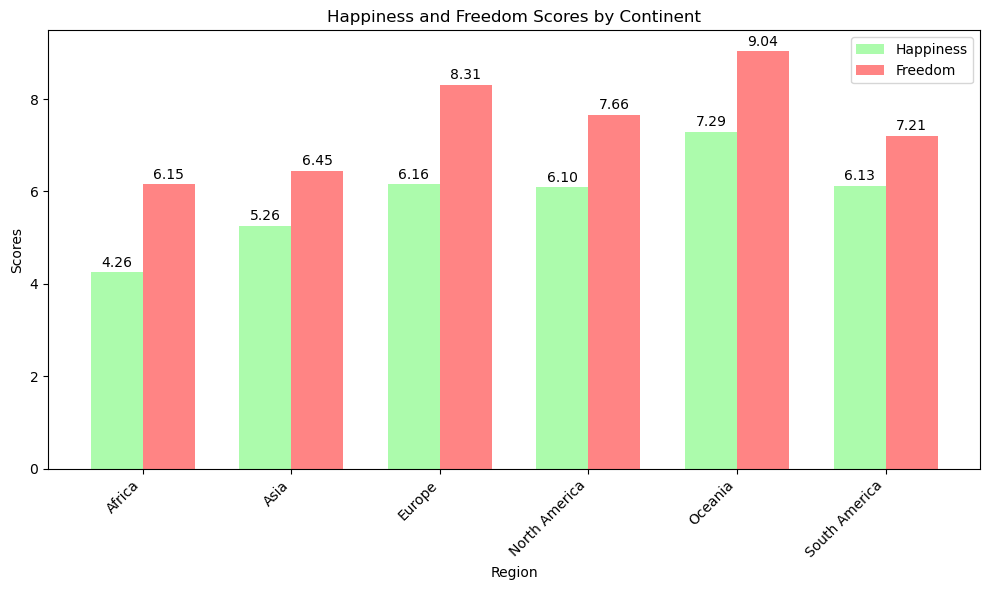

In [58]:
# Dati
continent = happy_free_by_continents['continent'].unique()
happiness_score_by_region = happy_free_by_continents.groupby('continent')['happiness_score'].mean()
freedom_score_by_region = happy_free_by_continents.groupby('continent')['hf_score'].mean()

# Impostazioni grafiche
bar_width = 0.35
opacity = 0.8
index = range(len(continent))

# Colori personalizzati
happiness_color = '#98FB98'
freedom_color = '#FF6666'

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
bars1 = plt.bar(index, happiness_score_by_region, bar_width, alpha=opacity, color=happiness_color, label='Happiness')
bars2 = plt.bar([i + bar_width for i in index], freedom_score_by_region, bar_width, alpha=opacity, color=freedom_color, label='Freedom')

# Altezza aggiuntiva per il testo
text_height = 0.05

# Aggiungi il valore di happiness_score su ogni barra
for bar, value in zip(bars1, happiness_score_by_region):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

# Aggiungi il valore di hf_score su ogni barra
for bar, value in zip(bars2, freedom_score_by_region):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

# Impostazioni sull'asse x
plt.xlabel('Region')
plt.ylabel('Scores')
plt.title('Happiness and Freedom Scores by Continent')
plt.xticks([i + bar_width/2 for i in index], continent, rotation=45, ha='right')  # Impostazione della posizione allineata al centro con rotazione

# Aggiunta di una legenda
plt.legend()

# Visualizzazione del grafico
plt.tight_layout()
plt.show()


<h2>Analisi per regione mondiale</h2>

In [59]:
happy_free_by_region = happy_free[['region', 'happiness_score', 'economy', 'family', 'health',
        'freedom', 'trust', 'generosity', 'hf_score',
        'pf_rol', 'pf_ss', 'pf_movement', 'pf_religion', 'pf_expression',
        'pf_identity', 'pf_score', 'ef_government',
        'ef_legal', 'ef_money', 'ef_trade', 'ef_regulation', 'ef_score',
        'pf_association']].groupby('region', as_index=False).mean()

In [60]:
happy_free_by_region[['region', 'happiness_score', 'hf_score']].sort_values('hf_score', ascending=False)

,region,happiness_score,hf_score
6,Oceania,7.294600,9.035000
5,North America,7.174700,8.860000
9,Western Europe,6.938967,8.750222
2,Eastern Europe,5.494991,7.973486
1,East Asia,5.651567,7.931667
3,Latin America & the Caribbean,6.014582,7.341273
0,Caucasus & Central Asia,5.011800,6.779000
7,South Asia,5.101473,6.423784
8,Sub-Saharan Africa,4.181541,6.321585
4,Middle East & North Africa,5.377911,5.437000


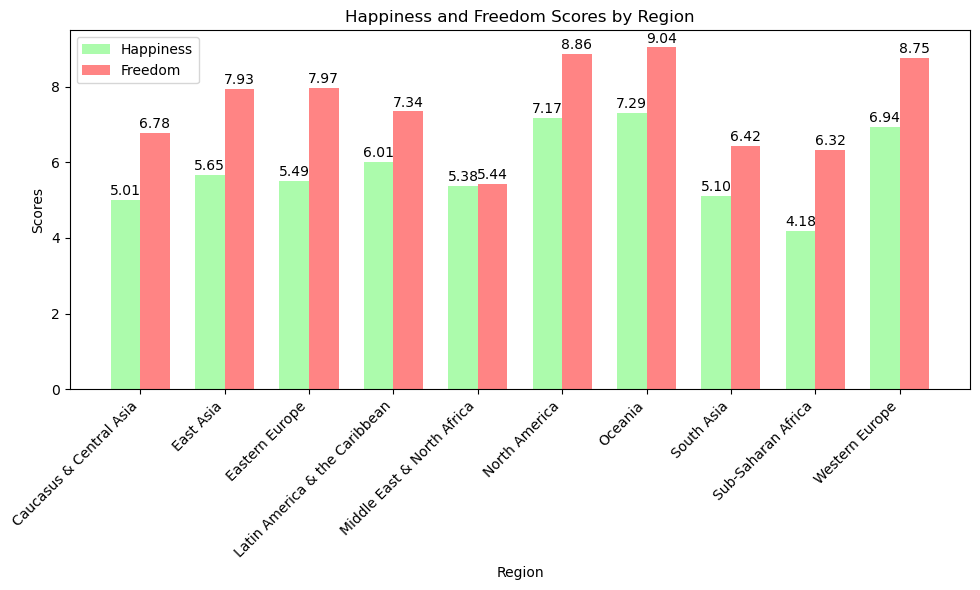

In [61]:
# Dati
region = happy_free_by_region['region'].unique()
happiness_score_by_region = happy_free_by_region.groupby('region')['happiness_score'].mean()
freedom_score_by_region = happy_free_by_region.groupby('region')['hf_score'].mean()

# Impostazioni grafiche
bar_width = 0.35
opacity = 0.8
index = range(len(region))

# Colori personalizzati
happiness_color = '#98FB98'
freedom_color = '#FF6666'

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
bars1 = plt.bar(index, happiness_score_by_region, bar_width, alpha=opacity, color=happiness_color, label='Happiness')
bars2 = plt.bar([i + bar_width for i in index], freedom_score_by_region, bar_width, alpha=opacity, color=freedom_color, label='Freedom')

# Altezza aggiuntiva per il testo
text_height = 0.05

# Aggiungi il valore di happiness_score su ogni barra
for bar, value in zip(bars1, happiness_score_by_region):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

# Aggiungi il valore di hf_score su ogni barra
for bar, value in zip(bars2, freedom_score_by_region):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + text_height, f'{value:.2f}', ha='center', va='bottom')

# Impostazioni sull'asse x
plt.xlabel('Region')
plt.ylabel('Scores')
plt.title('Happiness and Freedom Scores by Region')
plt.xticks([i + bar_width/2 for i in index], region, rotation=45, ha='right')  # Impostazione della posizione allineata al centro con rotazione

# Aggiunta di una legenda
plt.legend()

# Visualizzazione del grafico
plt.tight_layout()
plt.show()


<h2>Serie storica</h2>

In [ ]:
region = happy_free_by_region.region.unique()
happiness_score_by_region = happy_free_by_region.happiness_score
freedom_score_by_region = happy_free_by_region.hf_score

X_axis = np.arange(len(region)) 
  
plt.bar(X_axis - 0.2, happiness_score_by_region, 0.4, label = 'Happiness') 
plt.bar(X_axis + 0.2, freedom_score_by_region, 0.4, label = 'Freedom') 
  
plt.xticks(X_axis, region) 
plt.xlabel("Groups") 
plt.ylabel("Number of Students") 
plt.title("Number of Students in each group") 
plt.legend() 
plt.show() 

In [ ]:
world_happy_free = happy_free.merge(world, left_on='country', right_on='name', how='left')

In [ ]:
# 1. Calcolare la media di hf_score e happiness_score per regione
region_means = world_happy_free.groupby('region')[['hf_score', 'happiness_score']].mean()

In [ ]:
# 2. Unire le medie con il dataframe world_happy_free sulla colonna region
world_happy_free = world_happy_free.merge(region_means, on='region', suffixes=('', '_mean'))


In [ ]:

'''
# 2. Unire le medie con il dataframe world_happy_free sulla colonna region
world_happy_free = world_happy_free.merge(region_means, on='region')

# 3. Calcolare i centroidi delle regioni
region_centroids = world_happy_free.groupby('region').agg({'geometry': 'centroid'})

# 4. Creare una mappa usando Geopandas
fig, ax = plt.subplots(figsize=(10, 6))

# Plot della mappa usando Geopandas
world_happy_free.plot(column='hf_score', cmap='coolwarm', legend=True, ax=ax)

# Plot degli happiness_score come scatterplot rispetto alla media per regione
for region, centroid in region_centroids['geometry'].items():
    ax.scatter(centroid.x, centroid.y, s=region_means.loc[region, 'happiness_score'] * 100, c='black', marker='o', label=region)

plt.title('Happiness Score by Region')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Region')
plt.show()
'''


In [ ]:
#region = happy_free.region.unique()
happy_free.region.unique()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Creare un DataFrame per i centroidi delle regioni
region_centroids = happy_free_by_region.groupby('region')[['centroid_x', 'centroid_y']].mean()

# Calcola le dimensioni delle bolle basate sui valori scalati dell'happiness_score
bubble_sizes = np.abs(happy_free_by_region['happiness_score']) * 20

# Crea un grafico con geopandas
fig, ax = plt.subplots(figsize=(10, 6))

# Itera su ciascuna regione e aggiungi il suo scatterplot corrispondente
for region, data in happy_free_by_region.groupby('region'):
    # Utilizza il centroide medio come punto della regione
    region_centroid = region_centroids.loc[region]
    # Aggiungi i punti colorati in base all'happiness_score
    ax.scatter(region_centroid['centroid_x'], region_centroid['centroid_y'], s=bubble_sizes.loc[data.index], label=region)
    
# Aggiungi le linee dei confini degli stati
world.boundary.plot(ax=ax, color='gray', linewidth=0.5)

# Aggiungi una legenda
plt.legend(title='Region')
plt.title('Happiness Score by Region \n(Bubble Size Proportional to Score)')
plt.show()


In [ ]:
world.info()

In [ ]:
happy_free_by_region.head(10)

In [ ]:
print('pippo')